In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

In [2]:
#Systemic lupus erythematosus (SLE)
raw = sc.read_h5ad("GSE174188/GSE174188_CLUES1_adjusted.h5ad")
raw

AnnData object with n_obs × n_vars = 1263676 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
SLE = raw[raw.obs.Status != "Healthy", :]

del raw
SLE

View of AnnData object with n_obs × n_vars = 777258 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# 將細胞數量過少的移除
### 總細胞數 < 0.5% remove
### 總cell type數 < 0.5% remove

In [4]:
rows_to_remove = []
sample = list(set(SLE.obs.ind_cov))
for i in sample:
    if SLE[SLE.obs.ind_cov == i,:].n_obs < SLE.n_obs*0.005:
        rows_to_remove.append(i)
        
SLE_filter = SLE[~SLE.obs.ind_cov.isin(rows_to_remove),:]    

#del SLE
SLE_filter

View of AnnData object with n_obs × n_vars = 558952 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
# 原本 162人 remove < 0.05% after filter 94人
sample_filter = list(set(SLE_filter.obs.ind_cov))
len(sample_filter)

94

# Adjust cell type name

In [6]:
# 新建欄位把cell type做我要的分類
def classify_cell_type(value):
    if value == "pDC" or value == "cDC":
        return "DC"
    elif value == "cM" or value == "ncM":
        return "Monocyte"
    elif value == "T4":
        return "CD4 T"
    elif value == "T8":
        return "CD8 T"
    else:
        return value
    
SLE_filter.obs["cell_type"] = SLE_filter.obs["cg_cov"].apply(classify_cell_type)

C:\Users\benson\AppData\Local\Temp\ipykernel_29164\1899169293.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  SLE_filter.obs["cell_type"] = SLE_filter.obs["cg_cov"].apply(classify_cell_type)


In [17]:
personal = {}
for i in sample_filter:
    if i not in personal:
        personal[i] = SLE_filter[SLE_filter.obs.ind_cov == i, :]
len(personal)

93

In [18]:
# 將personal進行排序
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))
# 排序之後取得年齡
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])

age

['20.0',
 '21.0',
 '21.0',
 '21.0',
 '22.0',
 '23.0',
 '24.0',
 '25.0',
 '26.0',
 '27.0',
 '27.0',
 '27.0',
 '27.0',
 '27.0',
 '27.0',
 '28.0',
 '28.0',
 '29.0',
 '29.0',
 '29.0',
 '30.0',
 '31.0',
 '31.0',
 '31.0',
 '31.0',
 '32.0',
 '32.0',
 '33.0',
 '33.0',
 '34.0',
 '35.0',
 '35.0',
 '35.0',
 '36.0',
 '36.0',
 '37.0',
 '37.0',
 '37.0',
 '38.0',
 '38.0',
 '39.0',
 '39.0',
 '40.0',
 '40.0',
 '41.0',
 '41.0',
 '41.0',
 '42.0',
 '43.0',
 '43.0',
 '45.0',
 '45.0',
 '45.0',
 '46.0',
 '46.0',
 '48.0',
 '48.0',
 '49.0',
 '49.0',
 '50.0',
 '51.0',
 '51.0',
 '51.0',
 '52.0',
 '53.0',
 '54.0',
 '55.0',
 '55.0',
 '55.0',
 '55.0',
 '56.0',
 '57.0',
 '57.0',
 '58.0',
 '58.0',
 '58.0',
 '58.0',
 '59.0',
 '59.0',
 '60.0',
 '61.0',
 '64.0',
 '64.0',
 '64.0',
 '65.0',
 '66.0',
 '66.0',
 '66.0',
 '68.0',
 '70.0',
 '71.0',
 '71.0',
 '83.0']

# remove 1811_1811 因為B, plasma blast都是0

In [8]:
#del personal['1811_1811'],sorted_personal['1811_1811']
sample_filter.remove("1811_1811")

In [9]:
SLE_filter = SLE_filter[SLE_filter.obs.ind_cov != '1811_1811']
SLE_filter

View of AnnData object with n_obs × n_vars = 553271 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'cell_type'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
cell_type = list(set(SLE_filter.obs.cell_type))
cell_type

['Progen', 'Prolif', 'Monocyte', 'CD8 T', 'DC', 'NK', 'CD4 T', 'B', 'PB']

In [11]:
DC = SLE_filter[SLE_filter.obs.cell_type == 'DC',:]
Monocyte = SLE_filter[SLE_filter.obs.cell_type == 'Monocyte',:]
NK = SLE_filter[SLE_filter.obs.cell_type == 'NK',:]
CD8T = SLE_filter[SLE_filter.obs.cell_type == 'CD8 T',:]
CD4T = SLE_filter[SLE_filter.obs.cell_type == 'CD4 T',:]
B = SLE_filter[SLE_filter.obs.cell_type == 'B',:]

In [33]:
# 將原始 umap & kmeans的umap畫出來做比較
def umap_compare(cell_type, label):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))  # 創建一個1行2列的子圖

    # 用 KMeans 在資料中找出 2 個分組
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(cell_type.X)
    cell_type.obs["kmeans"] = kmeans.labels_
    sc.pl.umap(cell_type, color="kmeans", ax = axs[0], show=False)  # 不立即顯示圖形

    kmeans.fit(cell_type.obsm['X_pca'])
    cell_type.obs["kmeans"] = kmeans.labels_
    sc.pl.umap(cell_type, color="kmeans", ax = axs[1], show=False)
    
    plt.savefig(f'Result_picture/GSE174188/K-means proportion trend/umap_compare_{label}_SLE.png', dpi=900)
    plt.show()  # 顯示所有圖形

# 進行k_means後proportion的計算
def kmeans_proportion_trend(ID, cell_type_anndata):
    kmeans_1 = []
    kmeans_2 = []
    for i in ID:
        # Get individual cell types from person
        person = cell_type_anndata[cell_type_anndata.obs.ind_cov == i,: ]
        # Get cell types proportion through k-means
        kmeans_1.append(len(person[person.obs.kmeans == 0,:])/len(person.obs.kmeans))
        kmeans_2.append(len(person[person.obs.kmeans == 1,:])/len(person.obs.kmeans))
    return kmeans_1, kmeans_2

# 有按照年齡進行排序之後的kmeans比例
# 畫kmeans之後的cell proportion的趨勢
def trend_line(cell_type, label):
    plt.figure()
    plt.plot(cell_type, label=label)
    # 添加圖例
    plt.legend()

    # 計算趨勢線
    z = np.polyfit(range(len(cell_type)), cell_type, 1)
    p = np.poly1d(z)
    # 繪製趨勢線
    plt.plot(p(range(len(cell_type))),'r--', label='Trend Line')
    
    
    plt.savefig(f'Result_picture/GSE174188/K-means proportion trend/trend_{label}_SLE.png', dpi=900)    
    plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


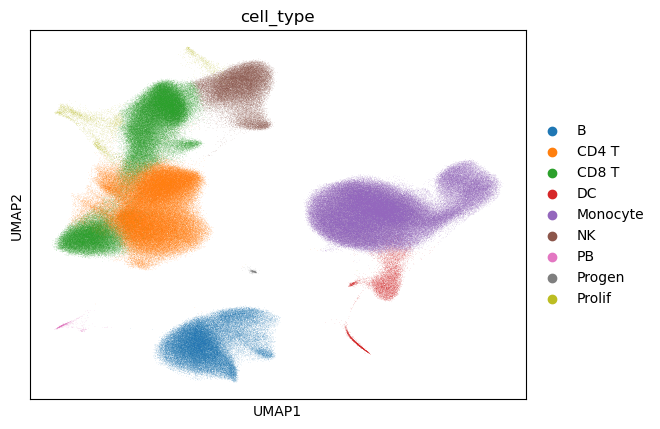

In [14]:
sc.pl.umap(SLE_filter, color="cell_type")

# NK

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


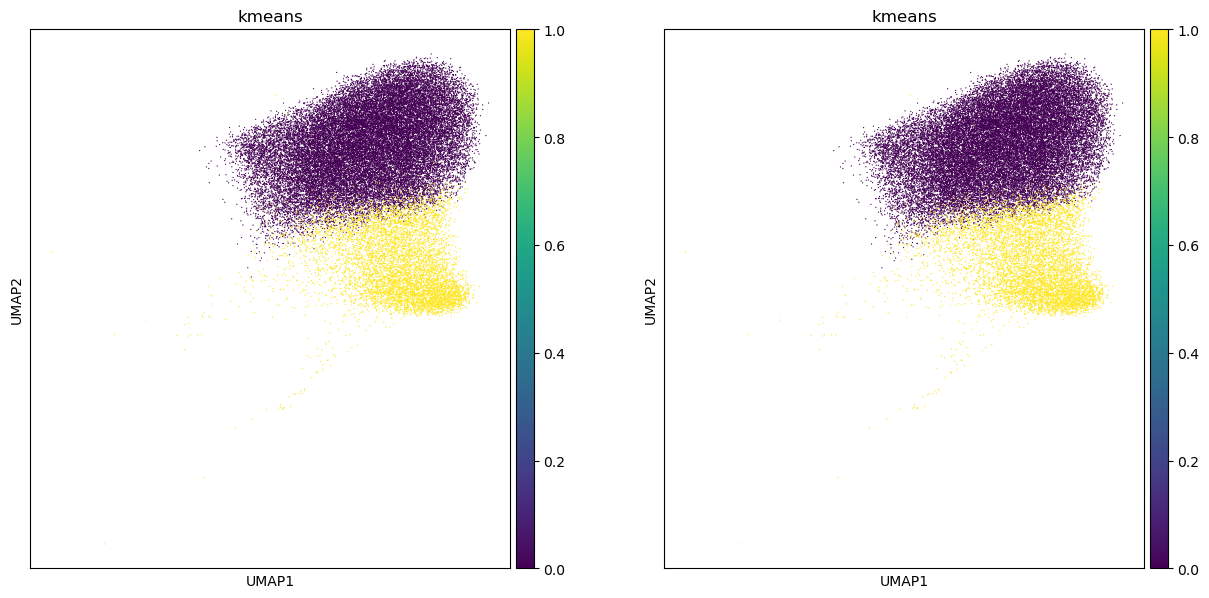

In [40]:
umap_compare(NK, "NK")

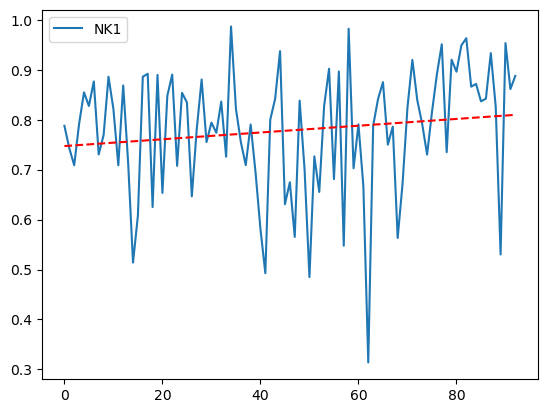

In [41]:
NK1, NK2 = kmeans_proportion_trend(sorted_personal, NK)
trend_line(NK1, "NK1")

# CD4 T

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


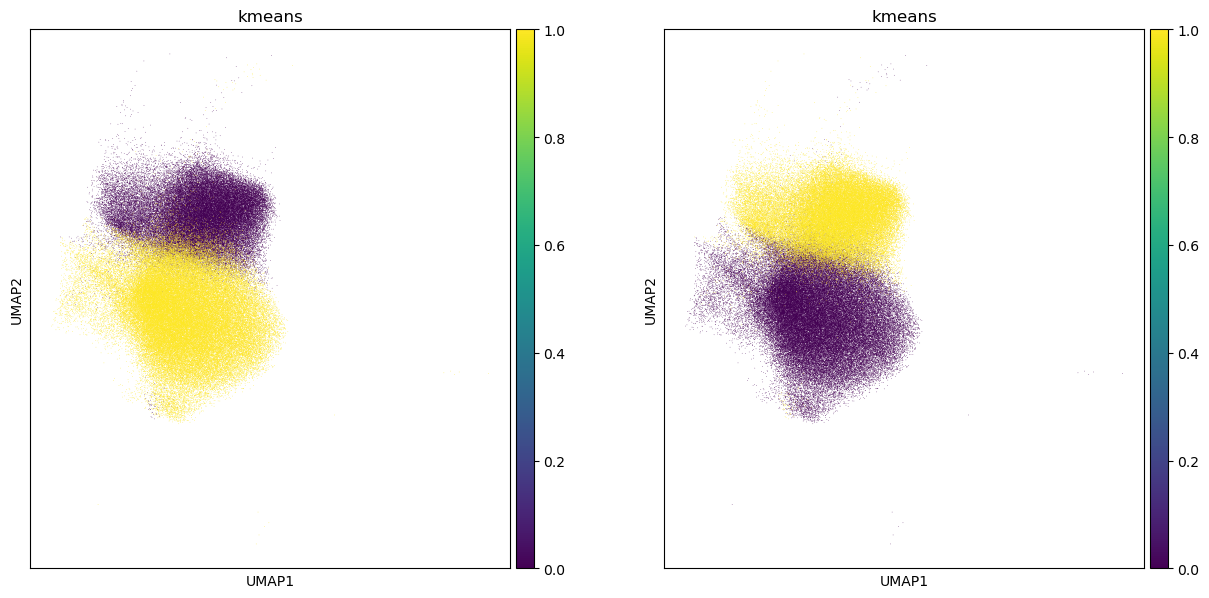

In [42]:
umap_compare(CD4T, "CD4 T")

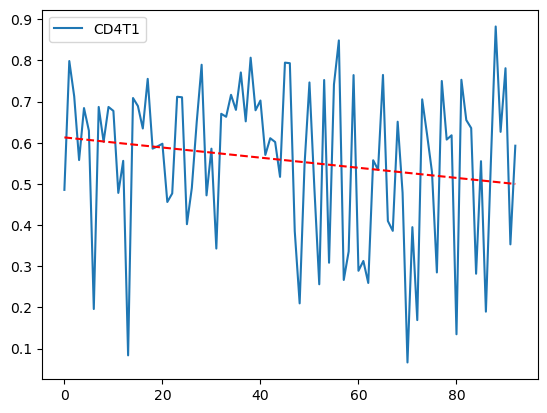

In [43]:
CD4T1, CD4T2 = kmeans_proportion_trend(sorted_personal, CD4T)
trend_line(CD4T1, "CD4T1")

# CD8 T

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


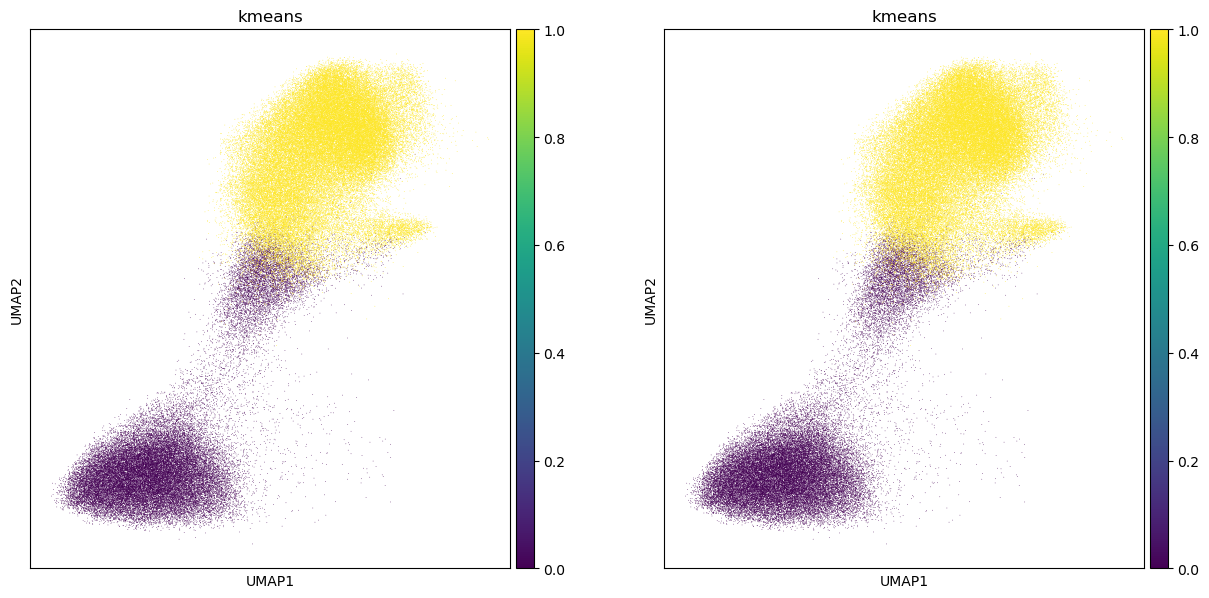

In [44]:
umap_compare(CD8T, "CD8 T")

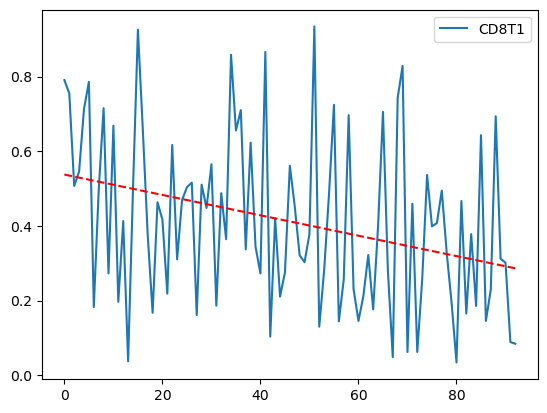

In [45]:
CD8T1, CD8T2 = kmeans_proportion_trend(sorted_personal, CD8T)
trend_line(CD8T1, "CD8T1")

# B

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


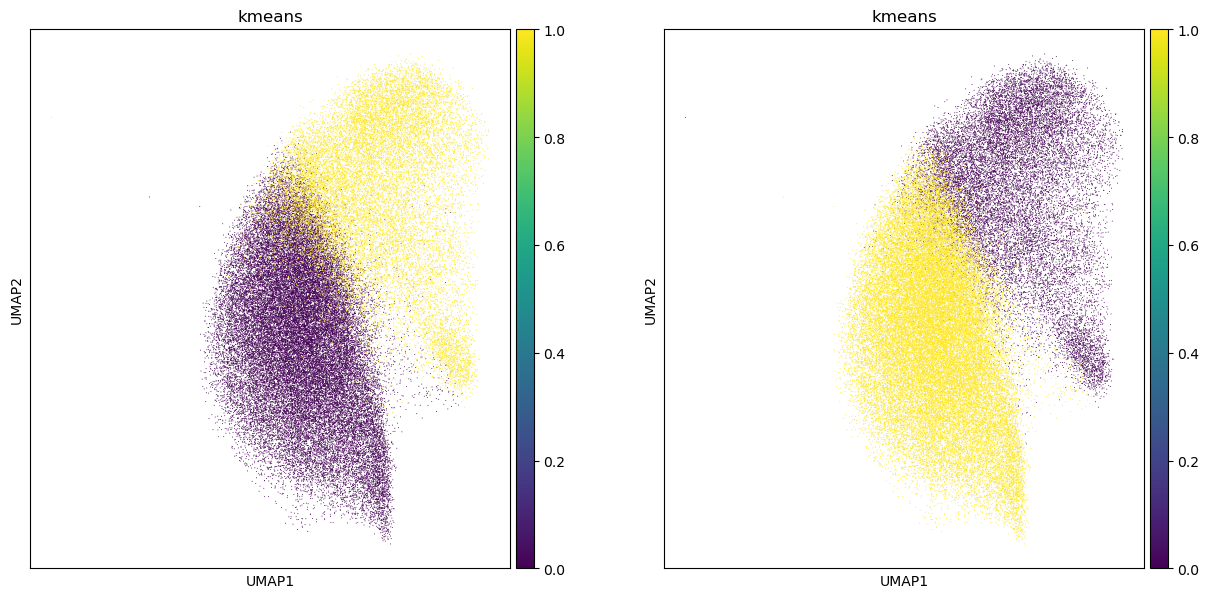

In [46]:
umap_compare(B, "B")

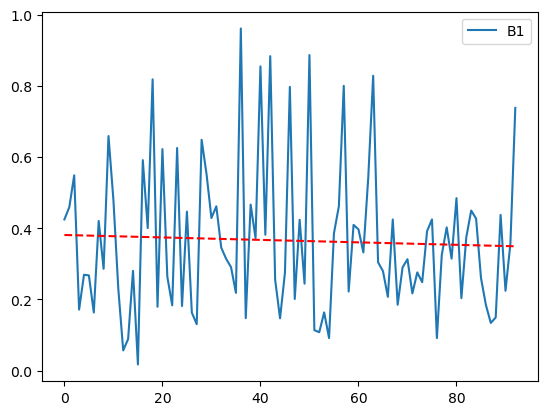

In [47]:
B1, B2 = kmeans_proportion_trend(sorted_personal, B)
trend_line(B1, "B1")

# Monocyte

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


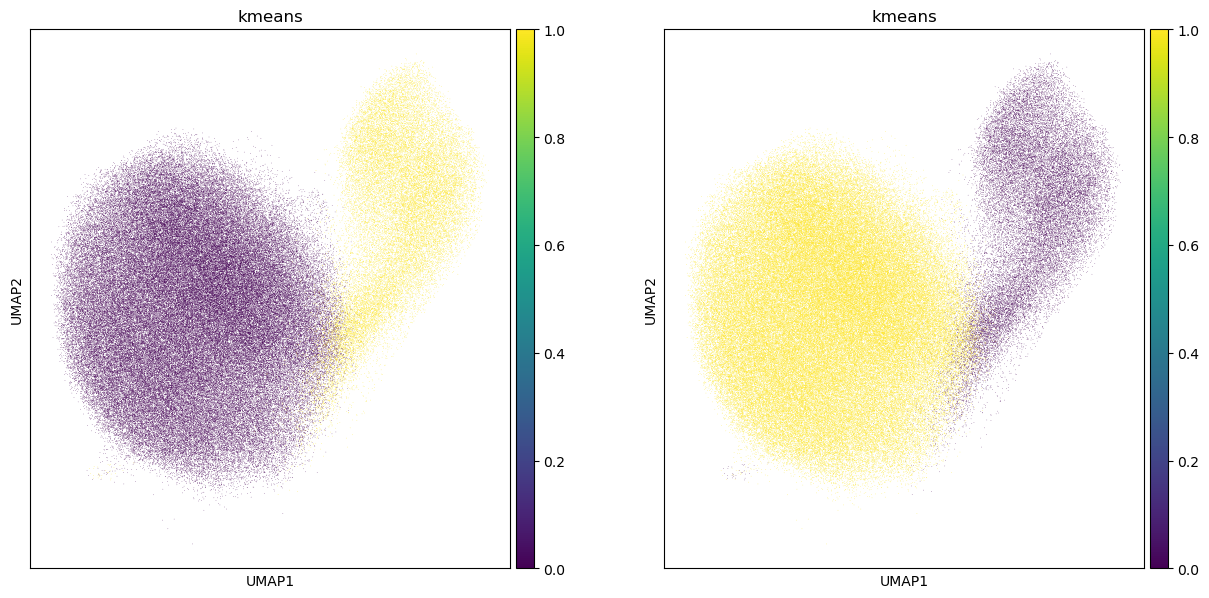

In [48]:
umap_compare(Monocyte,"Monocyte")

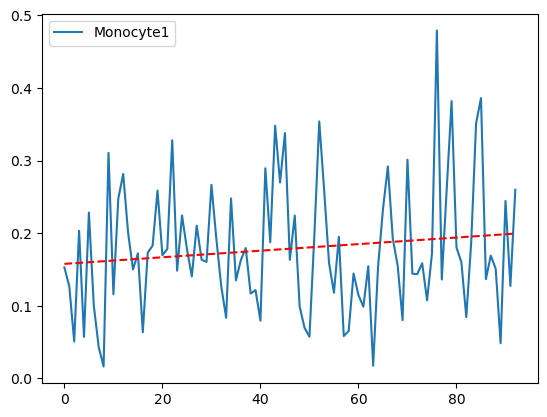

In [49]:
Monocyte1, Monocyte2 = kmeans_proportion_trend(sorted_personal, Monocyte)
trend_line(Monocyte1, "Monocyte1")

# DC

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


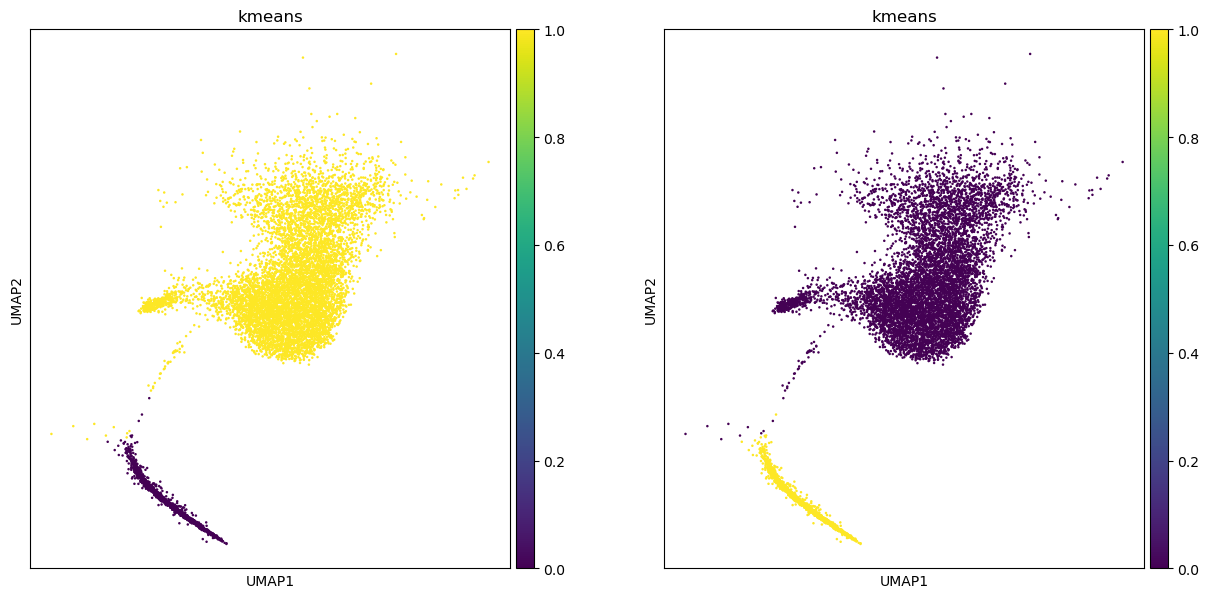

In [50]:
umap_compare(DC, "DC")

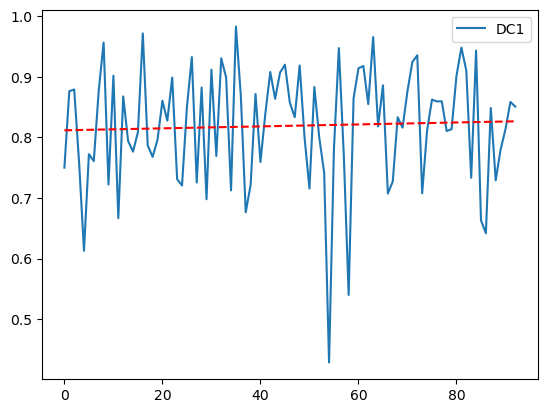

In [51]:
DC1, DC2 = kmeans_proportion_trend(sorted_personal, DC)
trend_line(DC1, "DC1")